In [1]:
import json
import os

import torch
from matplotlib import pyplot as plt

from data_utils import get_dataset_path, visualize_batch
from data_utils.BrainDataset import BrainDataset
from data_utils.BrainSampler import BrainSampler
from vae import VAE
from sklearn.decomposition import PCA
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model_name = "8225225804902"
model_dict = torch.load(os.path.join(get_dataset_path(), f"../models", f"{model_name}/model.pt"), weights_only=True)
options = json.load(open(os.path.join(get_dataset_path(), "../models", f"{model_name}/options.json"), "r"))
model = VAE(options["tile_size"], options["feature_space_dim"])
model.load_state_dict(model_dict)
model = model.eval()
model = model.to(device)

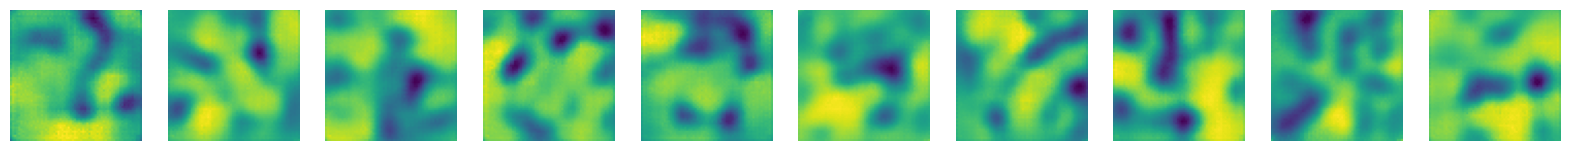

In [3]:
torch.random.manual_seed(0)
samples = model.sample(10)
visualize_batch(samples)

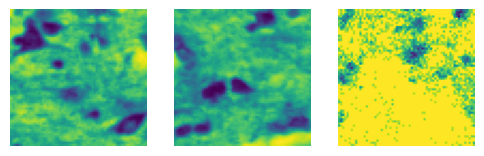

In [4]:
test_brain = "B20"
dataset = BrainDataset([test_brain])
img1 = dataset[(test_brain, 0, 0, 0, options["tile_size"])]
img2_shape = dataset.get_shape(test_brain, dataset.length-1)
# img2 = dataset[(test_brain, dataset.length-1,img2_shape[0]-options["tile_size"], img2_shape[1]- options["tile_size"], options["tile_size"])]
img2 = dataset[(test_brain, 0, 0, 64, options["tile_size"])]
img3 = dataset[(test_brain, 1, 0, 0, options["tile_size"])]
batch = torch.cat((img1, img2, img3), 0).unsqueeze(1)
visualize_batch(batch)

In [5]:
@torch.no_grad()
def interpolate(img1, img2, k):
    model.eval()
    img1, img2 = img1.to(device), img2.to(device)
    img1_enc, img2_enc = model.encode(img1.unsqueeze(0))[0], model.encode(img2.unsqueeze(0))[0]
    interpolations = torch.cat([(i+1)/(k+1) * img1_enc + (k - i)/(k+1) * img2_enc for i in range(k)])
    interpolations = model.decode(interpolations)
    visualize_batch(interpolations)

images from same region


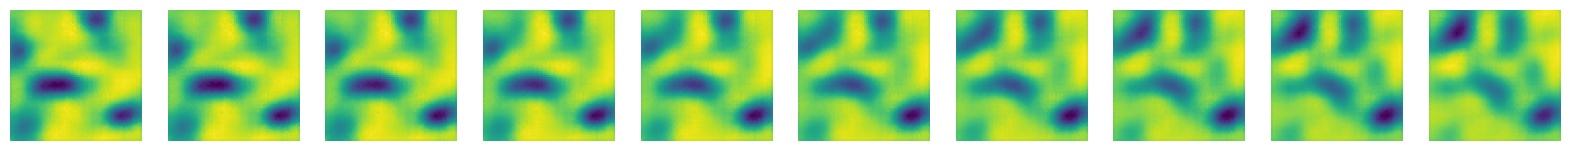

images from same section


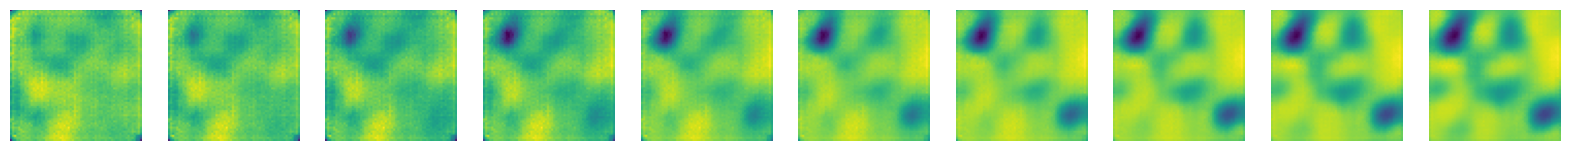

In [6]:
print("images from same region")
interpolate(img1, img2, k=10)
print("images from same section")
interpolate(img1, img3, k=10)


In [7]:
sample_tiles = []
sampler = BrainSampler(dataset, options["tile_size"], options["weighting"])
loader = iter(torch.utils.data.DataLoader(dataset, batch_size=options["batch_gpu"], sampler=sampler))
for i in range(3000//options["batch_gpu"] + 1):
    batch = next(loader).to(device)
    with torch.no_grad():
        enc = model.encode(batch)[0]
    sample_tiles.append(enc.cpu())
sample_tiles = torch.cat(sample_tiles, dim=0)

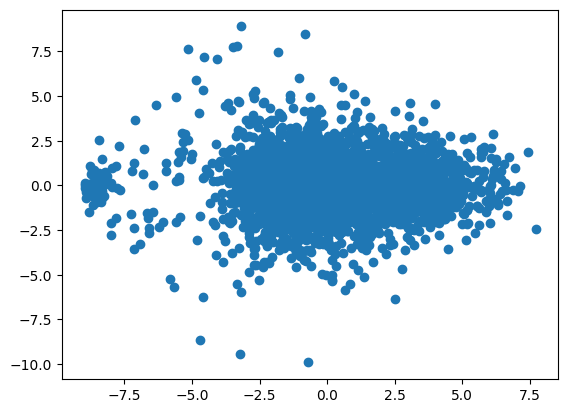

In [8]:
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(sample_tiles)
plt.scatter(pca_emb[:, 0], pca_emb[:, 1])